# load the data

In [101]:
import os
os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

import pandas as pd

training_data = pd.read_csv("train.csv")

X = training_data.drop(columns=["SalePrice", "Id"])
y = training_data["SalePrice"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)


# preprocess the data

In [102]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

from sklearn.preprocessing import OneHotEncoder

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# preprocess and convert to DataFrame for viewing
X_processed = preprocessor.fit_transform(X)
cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(categorical_features)
all_features = list(numeric_features) + list(cat_features)
X_processed_df = pd.DataFrame(X_processed.toarray(), columns=all_features)


# test various models and select the best

In [103]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, mutual_info_regression

# 1️⃣ Build a pipeline with a *placeholder* "selector" step
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("variance", VarianceThreshold(threshold=0.0)),
    ("selector", "passthrough"),      # will be replaced by GridSearchCV
    ("classifier", LinearRegression())
])

# 2️⃣ Tell GridSearchCV which options to try for "selector"
param_grid = {
    "selector": [
        "passthrough",
        SelectKBest(score_func=f_regression, k=100),
        SelectKBest(score_func=mutual_info_regression, k=100),
    ],
}

# 3️⃣ Wrap the pipeline in GridSearchCV
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,             # 5-fold cross-validation
    scoring="r2",     # use R² score for regression
    n_jobs=-1         # use all cores (optional, speeds things up)
)

# 4️⃣ Fit the whole thing
grid.fit(X_train, y_train)

# 5️⃣ Get the best pipeline (with the best selector choice)
best_pipeline = grid.best_estimator_

print("Best R²:", grid.best_score_)
print("Best selector:", grid.best_params_["selector"])

results = pd.DataFrame(grid.cv_results_)

# Show selector, mean score, std, and rank
summary = results[[
    "rank_test_score",
    "param_selector",
    "mean_test_score",
    "std_test_score"
]]

summary = summary.sort_values("rank_test_score")


Best R²: 0.8046728819182046
Best selector: SelectKBest(k=100, score_func=<function mutual_info_regression at 0x116d75800>)


# predict on the test data

In [104]:
y_pred_price = best_pipeline.predict(X_test)

# Take a look at a few predictions vs actual
predictions_vs_actual = pd.DataFrame({
    "ActualPrice": y_test.values,
    "PredictedPrice": pd.Series(y_pred_price).round().astype(int).values
})

# percent variance (Predicted - Actual) / Actual * 100, rounded to 2 decimals
predictions_vs_actual["Variance"] = (
    (predictions_vs_actual["PredictedPrice"] - predictions_vs_actual["ActualPrice"])
    / predictions_vs_actual["ActualPrice"]
) * 100

predictions_vs_actual["Variance"] = predictions_vs_actual["Variance"].round(2)


# classify the prices

In [106]:
# Use the training prices to define cut points (bins)
price_bins_labels = ["low", "medium", "high"]

# qcut will split y_train into 3 groups with roughly equal size
y_train_bins, price_bins_edges = pd.qcut(
    y_train,
    q=3,
    labels=price_bins_labels,
    retbins=True,
    duplicates="drop"  # in case of ties
)

# Convert true test prices into low/medium/high
y_test_clipped = np.clip(y_test.values, price_bins_edges[0], price_bins_edges[-1])
y_test_cat = pd.cut(
    y_test_clipped,
    bins=price_bins_edges,
    labels=price_bins_labels,
    include_lowest=True
)

# Convert predicted prices into low/medium/high
y_pred_clipped = np.clip(y_pred_price, price_bins_edges[0], price_bins_edges[-1])
y_pred_cat = pd.cut(
    y_pred_clipped,
    bins=price_bins_edges,
    labels=price_bins_labels,
    include_lowest=True
)

training_results = pd.DataFrame({
    "expected": y_test_cat,
    "predicted": y_pred_cat
})

training_results["correct"] = training_results["expected"] == training_results["predicted"]


# evaluate the model

              precision    recall  f1-score   support

        high       0.86      0.97      0.91        94
         low       0.85      0.88      0.86       115
      medium       0.76      0.61      0.68        83

    accuracy                           0.83       292
   macro avg       0.82      0.82      0.82       292
weighted avg       0.83      0.83      0.83       292



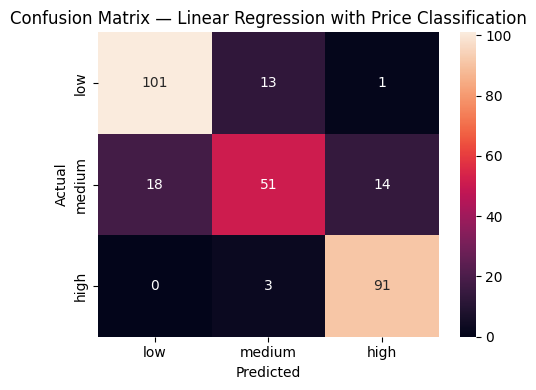

In [107]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test_cat, y_pred_cat))

cm = confusion_matrix(y_test_cat, y_pred_cat, labels=price_bins_labels)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=price_bins_labels,
    yticklabels=price_bins_labels
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Linear Regression with Price Classification")
plt.tight_layout()
plt.show()

# run model against the test data file

In [108]:
test_data = pd.read_csv("test.csv")
test_data["SalesPrice"] = best_pipeline.predict(test_data)

_, price_bins_edges = pd.qcut(
    test_data["SalesPrice"],
    q=3,
    labels=price_bins_labels,
    retbins=True,
    duplicates="drop"  # in case of ties
)

predictions = pd.cut(
    test_data["SalesPrice"],
    bins=price_bins_edges,
    labels=price_bins_labels,
    include_lowest=True
)

s = pd.Series(predictions)
counts = s.value_counts().rename("count")
percent = (counts / counts.sum() * 100).round(2).rename("percent")

summary = pd.concat([counts, percent], axis=1).reset_index()
summary = summary.rename(columns={"index": "PriceCategory"})

print(summary)



  SalesPrice  count  percent
0        low    487    33.38
1     medium    486    33.31
2       high    486    33.31
